In [9]:
!pip install scikit-plot
!pip install scikitplot

DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/dnspython-2.1.1.dev472+g8231eaa-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/dnspython-2.1.1.dev472+g8231eaa-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)
ERROR: No matching distribution found for scikitplot

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.11 -m pip install --upg

2024-08-04 18:01:17,030 - INFO - Data loaded successfully. Shape: (3000, 2)
2024-08-04 18:01:17,032 - INFO - Data split into training and test sets. Training set size: 2400, Test set size: 600


Fitting 3 folds for each of 8 candidates, totalling 24 fits


2024-08-04 18:01:31,671 - INFO - Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
2024-08-04 18:01:31,688 - INFO - Accuracy: 0.895
2024-08-04 18:01:31,689 - INFO - Classification Report:
2024-08-04 18:01:31,698 - INFO -               precision    recall  f1-score   support

       anger       0.95      0.87      0.91       118
        fear       0.97      0.85      0.90        99
         joy       0.77      0.93      0.84        96
        love       0.90      0.99      0.94       101
     sadness       0.96      0.73      0.82        91
    surprise       0.86      1.00      0.93        95

    accuracy                           0.90       600
   macro avg       0.90      0.89      0.89       600
weighted avg       0.90      0.90      0.89       600



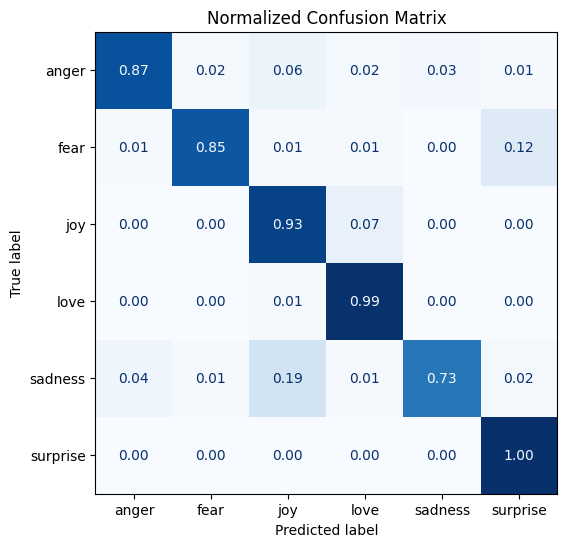

2024-08-04 18:01:31,792 - INFO - ROC AUC Score: 0.9759210414104723
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meanin

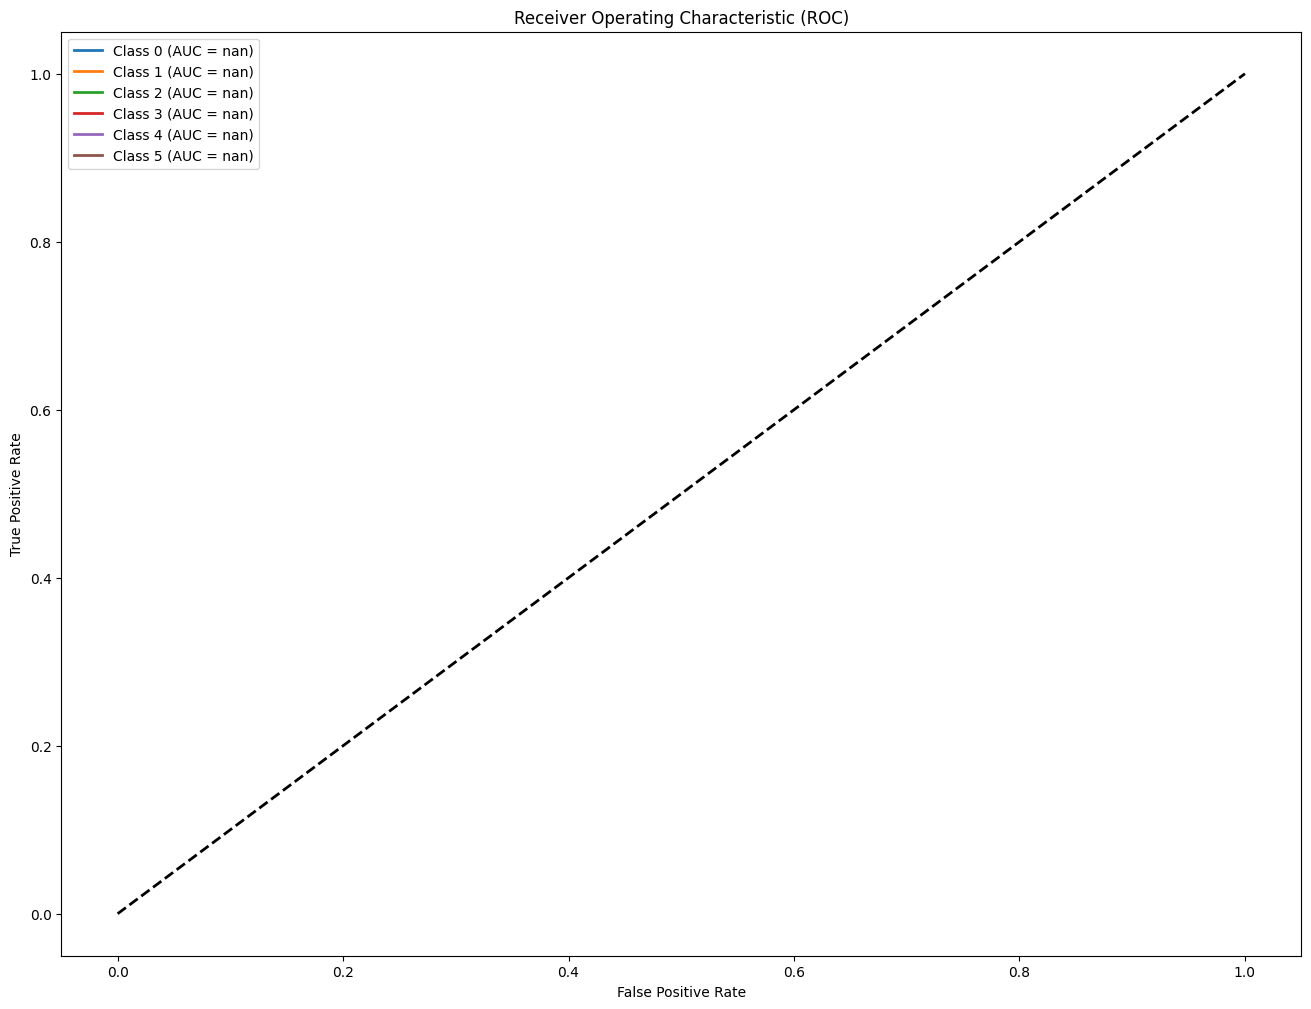

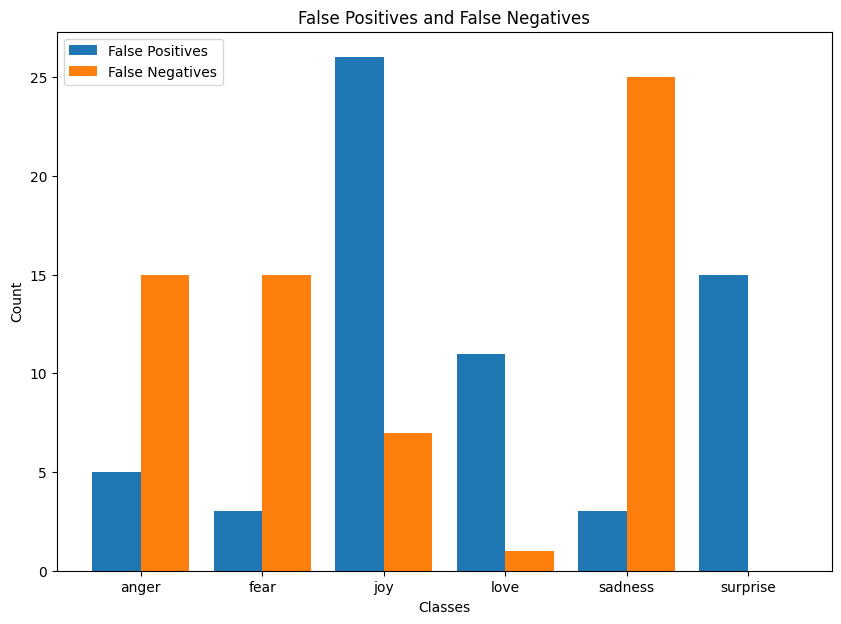

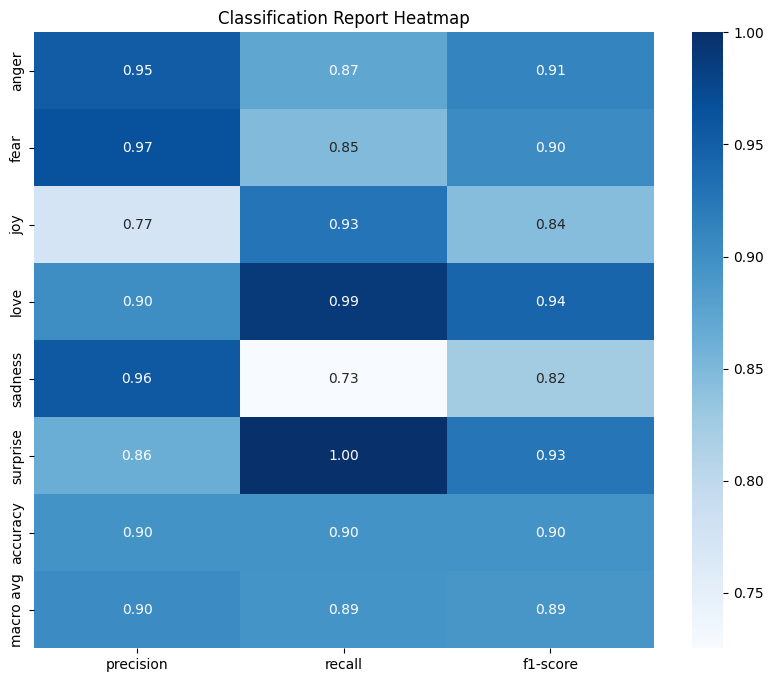

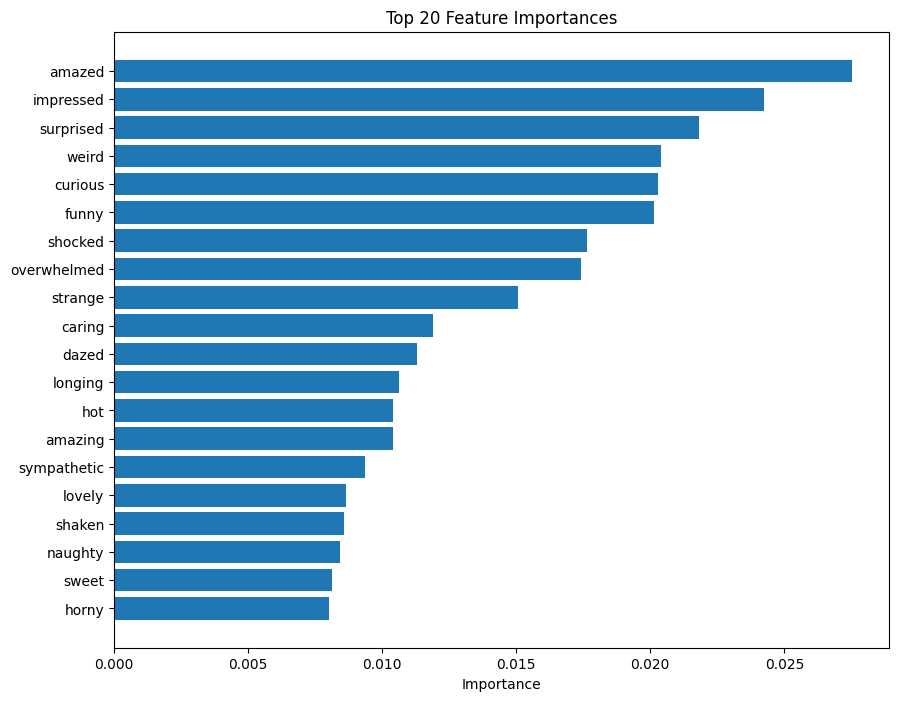

[learning_curve] Training set sizes: [ 192  384  576  768  960 1152 1344 1536 1728 1920]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.8s finished


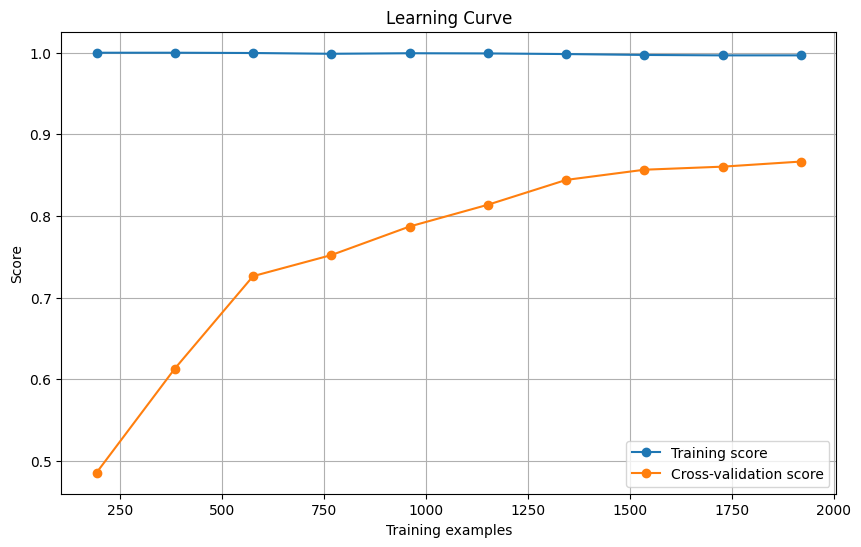

2024-08-04 18:01:51,223 - INFO - Model and vectorizer saved to ../trained_models/GBC_CV.pkl


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
import joblib
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.sparse import coo_matrix

from features import calculate_text_features_gbc_cv as calculate_text_features
from shared_functions import update_accuracy_in_config

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data(file_path):
    """Load data from CSV file."""
    try:
        df = pd.read_csv(file_path, header=None, names=['text', 'label'], delimiter=',', quoting=3)
        logging.info(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        logging.error(f"Error loading data: {str(e)}")
        raise

def preprocess_data(df):
    """Preprocess the data."""
    X = df['text'].astype(str)  # Ensure text data is string
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    logging.info(f"Data split into training and test sets. Training set size: {len(X_train)}, Test set size: {len(X_test)}")
    return X_train, X_test, y_train, y_test

def create_model():
    """Create a pipeline with CountVectorizer and GradientBoostingClassifier."""
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(max_features=5000, stop_words='english')),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
    return pipeline

def train_model(model, X_train, y_train):
    """Train the model with GridSearchCV."""
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5]
    }

    grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    logging.info(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

def evaluate_model(model, X_test, y_test):
    """Evaluate the model and print results."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logging.info(f'Accuracy: {accuracy}')
    logging.info('Classification Report:')
    logging.info(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)

    # Plot ROC curve and calculate AUC
    y_test_proba = model.predict_proba(X_test)  # Probabilities for all classes
    if len(y_test_proba.shape) == 2 and y_test_proba.shape[1] > 2:
        auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')  # One-vs-rest for multiclass
    else:
        auc = roc_auc_score(y_test, y_test_proba[:, 1])  # For binary classification
    logging.info(f'ROC AUC Score: {auc}')
    plot_roc_curve(y_test, y_test_proba)
    
    # Plot False Positives and False Negatives
    plot_fp_fn(y_test, y_pred)
        
    # Plot classification report
    plot_classification_report(y_test, y_pred)
    
    return accuracy

def plot_classification_report(y_true, y_pred):
    """Plot the classification report as a heatmap."""
    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Convert to DataFrame
    report_df = pd.DataFrame(report).transpose() 
    
    # Drop the 'support' column
    report_df = report_df.drop(columns=['support'], errors='ignore')

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap='Blues', fmt='.2f', cbar=True)
    plt.title('Classification Report Heatmap')
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()

def plot_roc_curve(y_test, y_test_proba):
    """Plot ROC curve."""
    fig, ax = plt.subplots(figsize=(16, 12))
    
    if len(y_test_proba.shape) == 2 and y_test_proba.shape[1] > 2:
        # Multiclass ROC
        for i in range(y_test_proba.shape[1]):
            fpr, tpr, _ = roc_curve(y_test == i, y_test_proba[:, i], pos_label=i)
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
    else:
        # Binary ROC
        fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC)')
    ax.legend(loc='best')
    plt.show()

def plot_feature_importances(model, vectorizer, X_train):
    """Plot feature importances."""
    vectorizer.fit(X_train)  # Fit vectorizer on training data
    features = vectorizer.get_feature_names_out()
    importances = model.named_steps['classifier'].feature_importances_

    # Convert importances to dense if needed
    if isinstance(importances, coo_matrix):  # Check if importances is a sparse matrix
        importances = importances.toarray().flatten()  # Convert to dense array
    elif isinstance(importances, np.ndarray) and importances.ndim > 1:  # Handle any multi-dimensional arrays
        importances = importances.flatten()

    # Ensure you are working with dense arrays
    importances = np.array(importances)
    feature_importances = sorted(zip(importances, features), reverse=True)
    top_features = feature_importances[:20]  # Top 20 features

    plt.figure(figsize=(10, 8))
    plt.barh([f[1] for f in top_features], [f[0] for f in top_features])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

def plot_learning_curve(model, X_train, y_train):
    """Plot learning curve."""
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), verbose=1
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def plot_fp_fn(y_true, y_pred):
    """Plot False Positives and False Negatives."""
    cm = confusion_matrix(y_true, y_pred)
    FP = cm.sum(axis=0) - np.diag(cm)  # False Positives
    FN = cm.sum(axis=1) - np.diag(cm)  # False Negatives
    classes = np.unique(y_true)

    plt.figure(figsize=(10, 7))
    width = 0.4  # Width of bars
    ind = np.arange(len(classes))  # Index for bars

    plt.bar(ind, FP, width, label='False Positives')
    plt.bar(ind + width, FN, width, label='False Negatives')

    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('False Positives and False Negatives')
    plt.xticks(ind + width / 2, classes)
    plt.legend(loc='best')
    plt.show()

def save_model(vectorizer, model, file_path):
    """Save the vectorizer and trained model."""
    joblib.dump((vectorizer, model), file_path)
    logging.info(f"Model and vectorizer saved to {file_path}")

# Load data
df = load_data('../sampled_data.csv')

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(df)

# Create and train model
model = create_model()
trained_model = train_model(model, X_train, y_train)

# Evaluate model
accuracy = evaluate_model(trained_model, X_test, y_test)

# Plot additional visualizations
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
plot_feature_importances(trained_model, vectorizer, X_train)
plot_learning_curve(trained_model, X_train, y_train)
save_model(vectorizer, trained_model, '../trained_models/GBC_CV.pkl')

# Update accuracy in config
update_accuracy_in_config(accuracy, 'count_gradient_boosting')
